# Extracting Tybalt Weights

The weights learned by the Tybalt model indicate patterns of gene expression variably activated across tumors. As Tybalt is an unsupervised model, these weights learned can point to known biology, unknown biology, or unrelated noise. One of the benefits of a variational autoencoder (VAE), is that the weights learned that represent each encoding are  nonlinear. Therefore, they can extract out signal representative of noise while still retaining relevant known and unknown biology.

Here, we extract the weights learned by the VAE and save them to file. We also explore specific signals that should be present in the data:

1. Signals representing the sex of the patient
2. Melanoma activation patterns.

In [1]:
import os
import pandas as pd
from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
sns.set(style='white', color_codes=True)
sns.set_context('paper', rc={'font.size':8, 'axes.titlesize':10, 'axes.labelsize':15})   

In [3]:
%matplotlib inline
plt.style.use('seaborn-notebook')

Because of the complex architecture involved in encoding the data, we will use the `decoded` weights to describe feature encoding specific activation patterns

In [4]:
# Load the decoder model
decoder_model_file = os.path.join('models', 'decoder_onehidden_vae.hdf5')
decoder = load_model(decoder_model_file)

/home/gway/anaconda3/envs/vae_pancancer/lib/python2.7/site-packages/keras/models.py:258: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
# Load RNAseq file
rnaseq_file = os.path.join('data', 'pancan_scaled_zeroone_rnaseq.tsv.gz')
rnaseq_df = pd.read_table(rnaseq_file, index_col=0)
rnaseq_df.head(2)

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
TCGA-02-0047-01,0.678296,0.289910,0.034230,0.0,0.0,0.084731,0.031863,0.037709,0.746797,0.687833,...,0.440610,0.428782,0.732819,0.634340,0.580662,0.294313,0.458134,0.478219,0.168263,0.638497
TCGA-02-0055-01,0.200633,0.654917,0.181993,0.0,0.0,0.100606,0.050011,0.092586,0.103725,0.140642,...,0.620658,0.363207,0.592269,0.602755,0.610192,0.374569,0.722420,0.271356,0.160465,0.602560


In [6]:
# For a future pathway analysis, the background genes are important
# Also needed to set column names on weights
background_file = os.path.join('data', 'background_genes.txt')
background_genes = pd.DataFrame(rnaseq_df.columns)
background_genes.to_csv(background_file, index=False, header=False, sep='\t')

## Extract Tybalt weight matrix and write to file

In [7]:
# Extract the weights from the decoder model
weights = []
for layer in decoder.layers:
    weights.append(layer.get_weights())
    
weight_layer_df = pd.DataFrame(weights[1][0], columns=rnaseq_df.columns, index=range(1, 101))
weight_layer_df.index.name = 'encodings'
weight_layer_df.head(2)

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
encodings,,,,,,,,,,,,,,,,,,,,,
1,-0.038720,0.016661,0.029607,0.039584,-0.001849,0.012594,0.016473,0.012619,-0.041976,-0.035155,...,0.015413,-0.021422,-0.009609,-0.016911,0.001458,-0.014941,-0.008457,-0.028340,-0.004947,0.014693
2,-0.038551,0.025872,0.026606,0.014903,0.011040,-0.018997,0.002153,-0.003017,-0.042659,-0.044308,...,-0.007668,0.000821,0.020055,0.012365,0.010221,0.010597,-0.018201,0.031298,-0.014771,-0.012871


In [8]:
# Write the genes to file
weight_file = os.path.join('results', 'tybalt_gene_weights.tsv')
weight_layer_df.to_csv(weight_file, sep='\t')

## Extracting example patterns learned by Tybalt

Focusing on two examples: Sex-specific and tissue-specific activation

### Sex specific activation by node 82

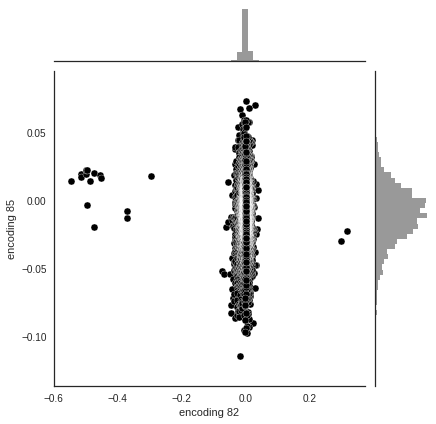

In [9]:
# We previously identified node 82 as robustly separating sex in the data set:
# Visualize the distribution of gene weights here
sex_node_plot = weight_layer_df.loc[[82, 85], :].T
sex_node_plot.columns = ['encoding 82', 'encoding 85']

sex_node_plot = (
    sex_node_plot.reindex(sex_node_plot['encoding 82'].abs()
                          .sort_values(ascending=False).index)
    )

g = sns.jointplot(x='encoding 82', y='encoding 85',
                  data=sex_node_plot, color='black',
                  edgecolor="w", stat_func=None);

# Save Figure
sex_node_plot_file = os.path.join('figures', 'sex_node_gene_scatter.pdf')
g.savefig(sex_node_plot_file)

In [10]:
# There are 17 genes with high activation in node 82
# All genes are located on sex chromosomes
sex_node_plot.head(17)

,encoding 82,encoding 85
EIF1AY,-0.543605,0.013644
UTY,-0.514367,0.019198
CYorf15A,-0.514013,0.016753
KDM5D,-0.499488,0.019061
DDX3Y,-0.497709,0.022053
TMSB4Y,-0.495302,-0.003714
USP9Y,-0.494874,0.022164
TTTY15,-0.487078,0.014047
NCRNA00185,-0.473645,-0.019878
CYorf15B,-0.472546,0.019967


By measuring expression of only *17 genes*, we can reliably predict the sex of the cancer patient. These are genes most expressed by sex chromosomes including x inactivating genes _XIST_ and _TSIX_.

### Node separating melanoma samples

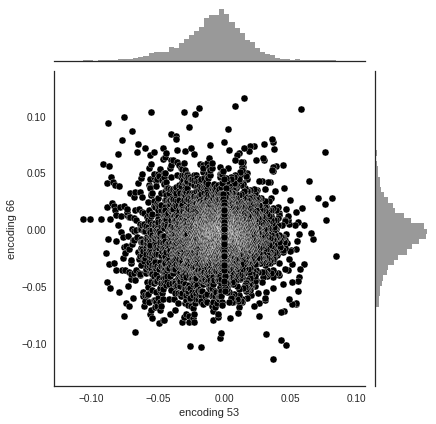

In [11]:
# We previously observed metastasis samples being robustly separated by two features
# Visualize the feature scores here
met_node_plot = weight_layer_df.loc[[53, 66], :].T
met_node_plot.columns = ['encoding 53', 'encoding 66']

met_node_plot = (met_node_plot.reindex(met_node_plot['encoding 53'].abs()
                                       .sort_values(ascending=False).index)
                 )
g = sns.jointplot(x='encoding 53', y='encoding 66',
                  data=met_node_plot, color='black',
                  edgecolor="w", stat_func=None);

# Save outputs
met_node_plot_file = os.path.join('figures', 'skcm_metastasis_node_gene_scatter.pdf')
g.savefig(met_node_plot_file)

#### Output high weight genes for two specific SKCM encodings

Because the genes involved in these nodes are not as cut and dry as the sex specific nodes, output the high weight genes explaining each tail of node 53 and 66. These will be processed though a pathway analysis downstream.

In [12]:
def output_high_weight_genes(weight_df, encoding, filename, thresh=2.5):
    """
    Function to process and output high weight genes given specific feature encodings
    """
    
    # Sort initial encoding by absolute activation
    encoding_df = (
        weight_df
        .reindex(weight_df[encoding].abs()
                 .sort_values(ascending=False).index)[encoding]
    )
    
    hw_pos_cutoff = encoding_df.mean() + (encoding_df.std() * thresh)
    hw_pos_df = pd.DataFrame(encoding_df[encoding_df > hw_pos_cutoff])
    hw_pos_df = hw_pos_df.assign(direction='positive')
    
    hw_neg_cutoff = encoding_df.mean() - (encoding_df.std() * thresh)
    hw_neg_df = pd.DataFrame(encoding_df[encoding_df < hw_neg_cutoff])
    hw_neg_df = hw_neg_df.assign(direction='negative')

    hw_df = pd.concat([hw_pos_df, hw_neg_df])
    hw_df.index.name = 'genes'
    hw_df.to_csv(filename, sep='\t')
    return hw_df

In [13]:
# Encoding 66
hw_node66_file = os.path.join('results', 'high_weight_genes_node66_skcm.tsv')
node66_df = output_high_weight_genes(met_node_plot, 'encoding 66', hw_node66_file)
node66_df.head(5)

,encoding 66,direction
genes,,
ROPN1,0.115224,positive
ROPN1B,0.108729,positive
ADIPOQ,0.107172,positive
SOX10,0.105733,positive
CIDEA,0.103107,positive


In [14]:
# Encoding 53
hw_node53_file = os.path.join('results', 'high_weight_genes_node53_skcm.tsv')
node53_df = output_high_weight_genes(met_node_plot, 'encoding 53', hw_node53_file)
node53_df.head(5)

,encoding 53,direction
genes,,
HCG22,0.084451,positive
RXRG,0.081329,positive
MGAT4C,0.076966,positive
PLP1,0.076440,positive
C10orf90,0.076005,positive
